In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.utils import resample



In [166]:
file_path = 'DelayedFlightsClean.csv'
flights_data = pd.read_csv(file_path)

In [167]:
flights_data['Delayed'] = (flights_data['ArrDelay'] > 0).astype(int)

In [168]:
flights_data_encoded = pd.get_dummies(flights_data, columns=['UniqueCarrier', 'Origin', 'Dest'], drop_first=True)

In [169]:
encoded_features = [
    'Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime', 'CRSElapsedTime',
    'Distance', 'TaxiIn', 'TaxiOut'
] + [col for col in flights_data_encoded.columns if col.startswith('UniqueCarrier_') or col.startswith('Origin_') or col.startswith('Dest_')]

In [170]:
X_encoded = flights_data_encoded[encoded_features]
y_encoded = flights_data_encoded['Delayed']

In [171]:
X_encoded.fillna(X_encoded.median(), inplace=True)

C:\Users\juanm\AppData\Local\Temp\ipykernel_8008\2250689829.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_encoded.fillna(X_encoded.median(), inplace=True)


In [172]:
flights_data_minority = flights_data_encoded[flights_data_encoded['Delayed'] == 0]
flights_data_majority = flights_data_encoded[flights_data_encoded['Delayed'] == 1]

flights_data_majority_downsampled = resample(flights_data_majority, 
                                             replace=False,    # sample without replacement
                                             n_samples=int(1.5*len(flights_data_minority)),  # to match minority class
                                             random_state=42)  # reproducible results

In [173]:
flights_data_balanced = pd.concat([flights_data_minority, flights_data_majority_downsampled])

In [174]:
X_encoded_balanced = flights_data_balanced[encoded_features]
y_encoded_balanced = flights_data_balanced['Delayed']

In [175]:
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X_encoded_balanced, y_encoded_balanced, test_size=0.3, random_state=42)

In [176]:
scaler = StandardScaler()
X_train_scaled_encoded = scaler.fit_transform(X_train_encoded)
X_test_scaled_encoded = scaler.transform(X_test_encoded)

In [177]:
logreg = LogisticRegression(max_iter=500)
selector = SelectFromModel(logreg)
selector.fit(X_train_scaled_encoded, y_train_encoded)

SelectFromModel(estimator=LogisticRegression(max_iter=500))

In [178]:
selected_features = X_encoded.columns[selector.get_support()]
X_train_selected = X_train_encoded[selected_features]
X_test_selected = X_test_encoded[selected_features]

In [179]:
X_train_scaled_selected = scaler.fit_transform(X_train_selected)
X_test_scaled_selected = scaler.transform(X_test_selected)

In [180]:
logreg_selected = LogisticRegression(max_iter=500)
logreg_selected.fit(X_train_scaled_selected, y_train_encoded)


LogisticRegression(max_iter=500)

In [181]:
y_pred_threshold = logreg_selected.predict(X_test_scaled_selected)


In [182]:
accuracy_selected = accuracy_score(y_test_encoded, y_pred_threshold)
report_selected = classification_report(y_test_encoded, y_pred_threshold)



print(f'Accuracy: {accuracy_selected:.2f}')
print('Reporte de clasificación:')
print(report_selected)


Accuracy: 0.71
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.66      0.57      0.61     61555
           1       0.73      0.80      0.77     92162

    accuracy                           0.71    153717
   macro avg       0.70      0.68      0.69    153717
weighted avg       0.70      0.71      0.70    153717



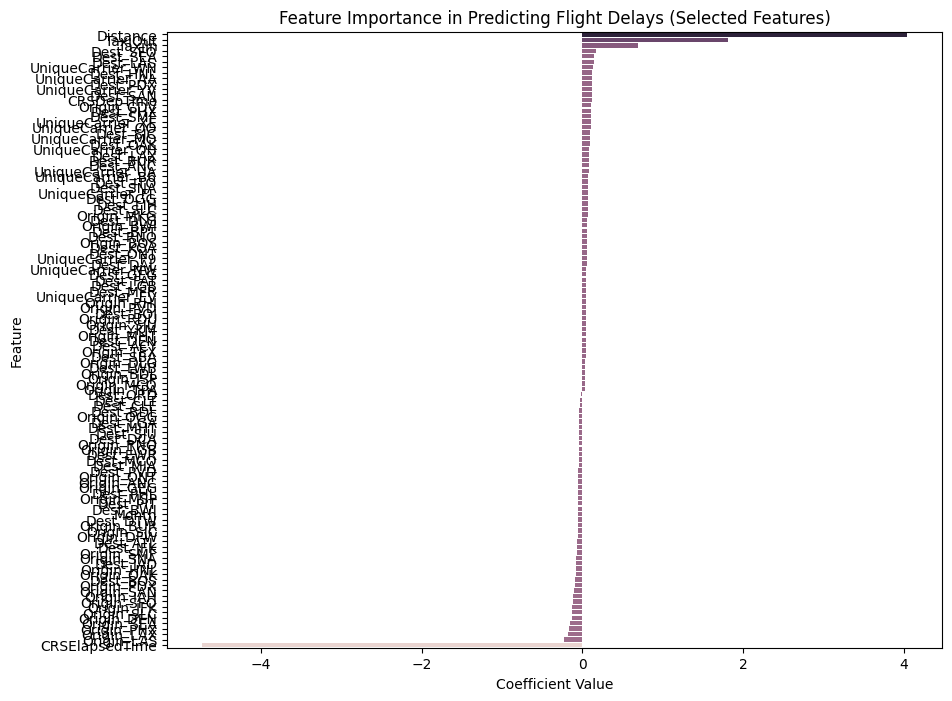

In [183]:
coefficients_selected = logreg_selected.coef_[0]
feature_importance_selected = pd.Series(coefficients_selected, index=selected_features).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importance_selected.values, y=feature_importance_selected.index, hue=feature_importance_selected.values, legend=False)
plt.title('Feature Importance in Predicting Flight Delays (Selected Features)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()
